In [2]:
import pandas as pd
import numpy as np
from random import sample
from random import seed
import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#Helper Functions Section

def pd_read_downsample(filename, per):
    n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
    s = round(n*per)
    skip = sorted(sample(range(1,n+1), n-s)) #the 0-indexed header will not be included in the skip list
    df = pd.read_csv(filename, parse_dates = [], skiprows=skip)
    return df
    #unclear if creating a downsampled csv file would be useful here or to just retain the
    #downsampled dataframe object
    df.to_csv(downsampled_filename)
    
#helper function to print columns with missing and the percentage missingness:
def colpercent(df):
    print("Total NaN in Dataframe: " , df.isnull().sum().sum())
    print("Percent Missingness in Dataframe: ", 100*df.isnull().sum().sum()/(len(df.index)*len(df.columns)))
    print('-'*55)
    percentnulldf = df.isnull().sum()/(df.isnull().sum()+df.notna().sum())
    print("Percent Missingness by Columns:")
    print(100*percentnulldf[percentnulldf>0].sort_values(ascending=False))
    
#printout to help view levels within features with missingness
def colpercount(df):
    percentnulldf = df.isnull().sum()/(df.isnull().sum()+df.notna().sum())
    percent_ordered_df=percentnulldf[percentnulldf>0].sort_values(ascending=False)
    for i in range(len(percent_ordered_df)):
        print(percent_ordered_df.index[i])
        print('-'*15)
        print(df[percent_ordered_df.index[i]].value_counts())
        print('-'*55)

#helper function to print out percentage of zeroes by column
def zeroper(df, value):
    l=[]
    columns=[]
    for i in range(len(df.columns)):
        if 0 in df[df.columns[i]].value_counts():
            if 100*df[df.columns[i]].value_counts().loc[0]/len(df[df.columns[i]])>value:
                l.append((df.columns[i], 100*df[df.columns[i]].value_counts().loc[0]/len(df[df.columns[i]])))
            else:
                pass
        else:
            pass
    
    print(len(l))    
    print('-'*55)
    for j in range(len(l)):
        columns.append(l[j][0])
        print('Percent of zeroes: ', l[j])
        print('-'*55)
    print(columns)
    return columns
    
#helper functions to characterize missingness by row and column
def data_eval(df):
    for i in range(len(df.columns)):
        print('-'*50)
        print('Column Name: ', df.columns[i])
        if (df[df.columns[i]].dtypes == 'float64' or df[df.columns[i]].dtypes == 'int64') and df[df.columns[i]][df[df.columns[i]]<0].count()>0:
            print('Number of negatives: ', df[df.columns[i]][df[df.columns[i]]<0].count())
        if df[df.columns[i]][df[df.columns[i]]=='None'].count() > 0:
            print('Number of None strings: ', df[df.columns[i]][df[df.columns[i]]=='None'].count())
        if df[df.columns[i]][df[df.columns[i]]==''].count() > 0:
            print('Number of empty strings: ', df[df.columns[i]][df[df.columns[i]]==''].count())
        else:
            print('Column ' + str(i) + ' has no negatives, empty strings or Nones')


#generates list of percentage missingness by row
def row_na_list(df, value):
    l=[]
    for i in range(len(df.index)) :
        if df.iloc[i].isnull().sum() > value:
            #print(i, df.iloc[i].isnull().sum())
            l.append(i)
    return l

#helper function to retrieve row and column index labels for correlation matrix values
#for greater than value when value>0 and less than value when value<0
#and prints out the values that correspond to those indices
def index_retrieve(df, value, measure):
    poslist = list()
    # Get bool dataframe with True at positions where the given value exists and filter out on-diagonal elements
    if measure == 'spearman':
        if value>0:
            result = df.corr(method = measure)[df.corr(method = measure)!=1][df.corr(method = measure)>value].isna().isin([value])
        if value<0:
            result = df.corr(method = measure)[df.corr(method = measure)!=1][df.corr(method = measure)<value].isna().isin([value])
        else:
            pass
    elif measure == 'pearson':
        if value>0:
            result = df.corr(method = measure)[df.corr(method = measure)!=1][df.corr(method = measure)>value].isna().isin([value])
        elif value<0:
            result = df.corr(method = measure)[df.corr(method = measure)!=1][df.corr(method = measure)<value].isna().isin([value])
        else:
            pass
    # Get list of columns that contains the value
    series = result.any()
    columnNames = list(series[series == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            poslist.append((row, col))
    # Return a list of tuples indicating the positions of value in the dataframe
    
    if value > 0:
        print('Number of correlations with value greater than ' + str(value) + ': ' + str(len(poslist)))
    if value < 0:
        print('Number of correlations with value less than ' + str(value) + ': ' + str(len(poslist)))
    else:
        pass
    for i in range(len(poslist)):
        print('-'*40)
        print('index labels: ', poslist[i][0], poslist[i][1])
        print('value at index: ', df.corr().loc[poslist[i]])
    return poslist

Alternative using bash:

For mac users who don't find shuf right away, please brew install first with brew install coreutils and then use the equivalence gshuf. This solution is much faster than calling random.

This is not in Pandas, but it achieves the same result much faster through bash, while not reading the entire file into memory:

shuf -n 100000 data/original.tsv > data/sample.tsv

The shuf command will shuffle the input and the and the -n argument indicates how many lines we want in the output.

Relevant question: https://unix.stackexchange.com/q/108581

Benchmark on a 7M lines csv available here (2008):

Top answer:

def pd_read():
    filename = "2008.csv"
    n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
    s = 100000 #desired sample size
    skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
    df = pandas.read_csv(filename, skiprows=skip)
    df.to_csv("temp.csv")

Timing for pandas:

%time pd_read()
CPU times: user 18.4 s, sys: 448 ms, total: 18.9 s
Wall time: 18.9 s

While using shuf:

time shuf -n 100000 2008.csv > temp.csv

real    0m1.583s
user    0m1.445s
sys     0m0.136s


from the following:
https://stackoverflow.com/questions/22258491/read-a-small-random-sample-from-a-big-csv-file-into-a-python-data-frame

In [6]:
csvlist[2]

'2013-09 - Citi Bike trip data.csv'

In [32]:
seed(0)
my_dfs = []
csvlist = [f for f in glob.glob("*.csv")]
i=1

for csv in csvlist:
    df_downsample = pd_read_downsample(csv, 0.01)
    df_downsample.columns = map(str.lower, df_downsample.columns)
    df_downsample.columns = df_downsample.columns.str.replace(" ", "")
    print('Now on loop', i, 'with number of features being', len(df_downsample.columns))
#     print('-'*55)
#     print('Feature names: ', df_downsample.columns)
    my_dfs.append(df_downsample)
    i = i + 1

Now on loop 1 with number of features being 15
-------------------------------------------------------
Feature names:  Index(['tripduration', 'starttime', 'stoptime', 'startstationid',
       'startstationname', 'startstationlatitude', 'startstationlongitude',
       'endstationid', 'endstationname', 'endstationlatitude',
       'endstationlongitude', 'bikeid', 'usertype', 'birthyear', 'gender'],
      dtype='object')
Now on loop 2 with number of features being 15
-------------------------------------------------------
Feature names:  Index(['tripduration', 'starttime', 'stoptime', 'startstationid',
       'startstationname', 'startstationlatitude', 'startstationlongitude',
       'endstationid', 'endstationname', 'endstationlatitude',
       'endstationlongitude', 'bikeid', 'usertype', 'birthyear', 'gender'],
      dtype='object')
Now on loop 3 with number of features being 15
-------------------------------------------------------
Feature names:  Index(['tripduration', 'starttime', '

Now on loop 21 with number of features being 15
-------------------------------------------------------
Feature names:  Index(['tripduration', 'starttime', 'stoptime', 'startstationid',
       'startstationname', 'startstationlatitude', 'startstationlongitude',
       'endstationid', 'endstationname', 'endstationlatitude',
       'endstationlongitude', 'bikeid', 'usertype', 'birthyear', 'gender'],
      dtype='object')
Now on loop 22 with number of features being 15
-------------------------------------------------------
Feature names:  Index(['tripduration', 'starttime', 'stoptime', 'startstationid',
       'startstationname', 'startstationlatitude', 'startstationlongitude',
       'endstationid', 'endstationname', 'endstationlatitude',
       'endstationlongitude', 'bikeid', 'usertype', 'birthyear', 'gender'],
      dtype='object')
Now on loop 23 with number of features being 15
-------------------------------------------------------
Feature names:  Index(['tripduration', 'starttime'

Now on loop 41 with number of features being 15
-------------------------------------------------------
Feature names:  Index(['tripduration', 'starttime', 'stoptime', 'startstationid',
       'startstationname', 'startstationlatitude', 'startstationlongitude',
       'endstationid', 'endstationname', 'endstationlatitude',
       'endstationlongitude', 'bikeid', 'usertype', 'birthyear', 'gender'],
      dtype='object')
Now on loop 42 with number of features being 15
-------------------------------------------------------
Feature names:  Index(['tripduration', 'starttime', 'stoptime', 'startstationid',
       'startstationname', 'startstationlatitude', 'startstationlongitude',
       'endstationid', 'endstationname', 'endstationlatitude',
       'endstationlongitude', 'bikeid', 'usertype', 'birthyear', 'gender'],
      dtype='object')
Now on loop 43 with number of features being 15
-------------------------------------------------------
Feature names:  Index(['tripduration', 'starttime'

Now on loop 61 with number of features being 15
-------------------------------------------------------
Feature names:  Index(['tripduration', 'starttime', 'stoptime', 'startstationid',
       'startstationname', 'startstationlatitude', 'startstationlongitude',
       'endstationid', 'endstationname', 'endstationlatitude',
       'endstationlongitude', 'bikeid', 'usertype', 'birthyear', 'gender'],
      dtype='object')
Now on loop 62 with number of features being 15
-------------------------------------------------------
Feature names:  Index(['tripduration', 'starttime', 'stoptime', 'startstationid',
       'startstationname', 'startstationlatitude', 'startstationlongitude',
       'endstationid', 'endstationname', 'endstationlatitude',
       'endstationlongitude', 'bikeid', 'usertype', 'birthyear', 'gender'],
      dtype='object')
Now on loop 63 with number of features being 15
-------------------------------------------------------
Feature names:  Index(['tripduration', 'starttime'

In [91]:
fin_dat = pd.read_csv('concat_file.csv')

In [93]:
#fin_dat = pd.concat(my_dfs, axis=0)
fin_dat = fin_dat.reset_index(drop=True)
fin_dat['starttime'] = pd.to_datetime(fin_dat.starttime)
fin_dat['stoptime'] = pd.to_datetime(fin_dat.stoptime)
fin_dat = fin_dat.drop('Unnamed: 0', axis=1)

In [94]:
fin_dat.head()

,tripduration,starttime,stoptime,startstationid,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,endstationlongitude,bikeid,usertype,birthyear,gender
0,278,2017-09-01 00:11:00,2017-09-01 00:15:39,325.0,E 19 St & 3 Ave,40.736245,-73.984738,402.0,Broadway & E 22 St,40.740343,-73.989551,17018,Customer,NaN,0
1,1082,2017-09-01 00:20:30,2017-09-01 00:38:32,368.0,Carmine St & 6 Ave,40.730386,-74.002150,279.0,Peck Slip & Front St,40.707873,-74.001670,27115,Subscriber,1991,1
2,839,2017-09-01 00:20:54,2017-09-01 00:34:53,3411.0,Bond St & Bergen St,40.684967,-73.986208,3365.0,3 St & 7 Ave,40.670384,-73.978397,28723,Subscriber,1976,1
3,445,2017-09-01 00:34:24,2017-09-01 00:41:49,3461.0,Murray St & Greenwich St,40.714852,-74.011223,368.0,Carmine St & 6 Ave,40.730386,-74.002150,15336,Subscriber,1987,1
4,336,2017-09-01 00:38:31,2017-09-01 00:44:08,3118.0,McGuinness Blvd & Eagle St,40.735550,-73.952840,3476.0,Norman Ave & Leonard St,40.725770,-73.950740,14763,Subscriber,1982,2


In [95]:
#na survey of data after import
colpercent(fin_dat)

Total NaN in Dataframe:  51193
Percent Missingness in Dataframe:  0.3662451767249412
-------------------------------------------------------
Percent Missingness by Columns:
birthyear              5.346015
usertype               0.056661
endstationname         0.022750
endstationid           0.022750
endstationlongitude    0.019746
endstationlatitude     0.019746
startstationname       0.003005
startstationid         0.003005
dtype: float64


In [101]:
#birthyear column na handling and imputation

#the number of na versus not na
print(fin_dat.birthyear.isnull().value_counts())

#this indicates that some of the years are cast as floats while others are strings
print(fin_dat.birthyear[fin_dat.birthyear.notnull()].value_counts()[200:].index)

#data is inconsistent in some na's being whitespace and others being actual na's, so replace for consistency
fin_dat.birthyear = fin_dat.birthyear.replace('\\N', np.nan)
fin_dat.birthyear.fillna(1900.0, inplace=True)
fin_dat.birthyear = fin_dat.birthyear[fin_dat.birthyear.notnull()].astype('float16')
print('imputation complete')

False    881891
True      49750
Name: birthyear, dtype: int64
Index(['1938.0', '1900.0',   1932.0,   '1935',   '1934',   1933.0,   1885.0,
         1901.0,   '1932',   '1936',   '1933',   1934.0,   '1930',   1910.0,
         1930.0, '1885.0',   1923.0, '1939.0',   '1899',   1888.0,   1912.0,
         1921.0,   '1923',   1899.0, '2001.0',   '1924', '1936.0',   '1901',
         '1888', '1937.0', '1935.0',   1896.0,   1886.0,   1919.0,   1924.0,
         1926.0,   1895.0, '1901.0',   1918.0,   '1921',   1894.0, '1934.0',
         '1907',   '1926',   '1890',   1890.0,   1929.0,   1913.0,   1887.0,
         '1922',   '1885', '1918.0',   '1895', '1932.0',   '1912',   '1910',
         '1931',   1893.0,   '1887',   '1917',   1911.0,   '1893',   1917.0,
         1922.0,   '1909',   '1894',   1927.0,   1928.0,   1889.0, '1874.0',
       '1917.0',   '1918', '1926.0',   '1915', '1933.0', '1888.0',   '1886',
       '1913.0', '1899.0', '1921.0',   '1929', '1923.0',   '1889', '1894.0',
         1925.

In [102]:
#birthyear column imputation for implausibly elderly

#these ages seem implausible (Citibike starting in 2013 would put the most elderly rider at 94), 
#so we replace them with 1900.0
birth_index = fin_dat.birthyear[fin_dat.birthyear.sort_values(ascending=False)<1920.0].index
print(fin_dat.birthyear[birth_index].unique())
fin_dat.birthyear[birth_index] = fin_dat.birthyear[birth_index].replace(list(fin_dat.birthyear[birth_index].unique()), 1900.0)
print('imputation complete')

[1900. 1894. 1885. 1895. 1887. 1912. 1907. 1899. 1918. 1890. 1886. 1901.
 1896. 1910. 1911. 1888. 1919. 1909. 1913. 1874. 1893. 1917. 1889. 1915.]
imputation complete


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [96]:
#usertype column na handling and imputation

#alternative is to look into proportional imputation by class
fin_dat.usertype.fillna('Unknown', inplace=True)
print('imputation complete')

imputation complete


In [97]:
#endstation na handling and imputation

#the missing station names, id, lat and long indexes coincide, so these observations cannot be used for route analysis and should be removed
print(fin_dat.endstationname[fin_dat.endstationname.isnull()].index)
print(fin_dat.endstationid[fin_dat.endstationid.isnull()].index)
print(fin_dat.endstationlatitude[fin_dat.endstationlatitude.isnull()].index)
print(fin_dat.endstationlongitude[fin_dat.endstationlongitude.isnull()].index)

fin_dat.drop(fin_dat[fin_dat.endstationid.isnull()].index, axis=0, inplace=True)

print('imputation complete')

Int64Index([ 19473,  23998,  24060,  24991,  26204,  34255,  36595,  37465,
             37547, 527886,
            ...
            683380, 683469, 683481, 683521, 683578, 683616, 746223, 818138,
            821851, 829418],
           dtype='int64', length=212)
Int64Index([ 19473,  23998,  24060,  24991,  26204,  34255,  36595,  37465,
             37547, 527886,
            ...
            683380, 683469, 683481, 683521, 683578, 683616, 746223, 818138,
            821851, 829418],
           dtype='int64', length=212)
Int64Index([678030, 678048, 678125, 678129, 678151, 678168, 678188, 678222,
            678234, 678270,
            ...
            683148, 683178, 683237, 683360, 683380, 683469, 683481, 683521,
            683578, 683616],
           dtype='int64', length=184)
Int64Index([678030, 678048, 678125, 678129, 678151, 678168, 678188, 678222,
            678234, 678270,
            ...
            683148, 683178, 683237, 683360, 683380, 683469, 683481, 683521,
            683

In [98]:
#startstation na handling and imputation

#the missing station names and id indexes coincide, so these observations cannot be used for route analysis and should be removed
print(fin_dat.startstationname[fin_dat.startstationname.isnull()].index)
print(fin_dat.startstationid[fin_dat.startstationid.isnull()].index)

fin_dat.drop(fin_dat[fin_dat.startstationid.isnull()].index, axis=0, inplace=True)

print('imputation complete')

Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
imputation complete


In [99]:
#now that imputations and removals are completed, we need to reset index

fin_dat = fin_dat.reset_index(drop=True)

In [103]:
#to verify all nas are gone
colpercent(fin_dat)

Total NaN in Dataframe:  0
Percent Missingness in Dataframe:  0.0
-------------------------------------------------------
Percent Missingness by Columns:
Series([], dtype: float64)


Initial Notes:
1. Need to convert starttime and stoptime to datetime format or equivalent. This can be done automatically while reading in  with the parse_dates method, but would be faster to do selectively after downsampling. The former may be unavoidable if the groupby needs to be done by month though
2. Implement downsampling, ideally read in directly as such

In [89]:
#timeDelta method for computing time of travel
print((fin_dat.stoptime - fin_dat.starttime).dt.total_seconds().sort_values(ascending=False))

#for more information if method is insufficiently time-efficient
#https://pandas.pydata.org/pandas-docs/stable/user_guide/timedeltas.html
#https://stackoverflow.com/questions/22923775/calculate-pandas-dataframe-time-difference-between-two-columns-in-hours-and-minu
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.total_seconds.html

#error in starttime and stoptime labeling, need to reverse what is starttime and what is stoptime
#we will assume here that all station labels are correct, simply start and stoptimes were inserted incorrectly
fin_dat.iloc[539645,:]

fin_dat.iloc[539645,:].starttime, fin_dat.iloc[539645,:].stoptime = fin_dat.iloc[539645,:].stoptime, fin_dat.iloc[539645,:].starttime

fin_dat.iloc[539645,:]

86586     1.951365e+07
832547    3.553060e+06
254056    2.306980e+06
243703    2.185878e+06
888973    2.055866e+06
              ...     
721367    6.000000e+01
171928    6.000000e+01
779900    6.000000e+01
794724    6.000000e+01
539645   -2.237000e+03
Length: 911813, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


tripduration                              4963
starttime                  2015-11-01 01:48:36
stoptime                   2015-11-01 01:11:19
startstationid                             152
startstationname         Warren St & Church St
startstationlatitude                   40.7147
startstationlongitude                 -74.0091
endstationid                               302
endstationname               Avenue D & E 3 St
endstationlatitude                     40.7208
endstationlongitude                   -73.9779
bikeid                                   23060
usertype                            Subscriber
birthyear                                 1991
gender                                       1
Name: 539645, dtype: object

In [64]:
diff=fin_dat.tripduration-(fin_dat.stoptime - fin_dat.starttime).dt.total_seconds()
#this indicates that only around 1/4 of the observations are in agreement
print(len(diff[diff==0]))
print('-'*45)
#a large majority of the observations are either in agreement or the differences are due to rounding error
#these are sufficiently close that we can for our purposes just keep the values we already have in tripduration
print(len(diff[abs(diff)<=1]))
print('-'*45)
#only around 8400 observations have actual errors
print(diff[abs(diff>1)])

275676
---------------------------------------------
883442
---------------------------------------------
169082       5.0
169083      22.0
169084       3.0
169085       5.0
169086      23.0
           ...  
813459      31.0
813460      28.0
813462      13.0
813463      45.0
908612    3600.0
Length: 8388, dtype: float64


In [65]:
error_index = diff[abs(diff>1)].index
#there are no negative values here
#print(fin_dat.tripduration[error_index][fin_dat.tripduration[error_index]<0])
# print('-'*45)
print(fin_dat.iloc[error_index, 0])
# print('-'*45)
# print(fin_dat.tripduration[error_index] + diff[abs(diff>1)])

169082        545
169083       1462
169084        303
169085        245
169086        203
           ...   
813459        271
813460       1948
813462        433
813463        705
908612    2059466
Name: tripduration, Length: 8388, dtype: int64


In [104]:
#made correction to update tripduration values with error
fin_dat.tripduration[error_index] = fin_dat.tripduration[error_index] + diff[abs(diff>1)]
print('imputation complete')

imputation complete


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [105]:
fin_dat.tripduration[error_index]

169082     277.0
169083     653.0
169084     783.0
169085     223.0
169086    1245.0
           ...  
813459     910.0
813460     334.0
813462    1514.0
813463     261.0
908612    4010.0
Name: tripduration, Length: 8388, dtype: float64

In [106]:
#print(fin_dat.tripduration.sort_values(ascending=True)[:10000])
#issue with riders getting bike and then shortly after returning them to same dock station without real use.
#print(fin_dat.iloc[663912,:])

#remove observations where cyclists return bike to same dock
#fin_dat.drop(fin_dat.iloc[fin_dat.startstationid == fin_dat.endstationid], axis=1)
fin_dat.loc[fin_dat.startstationid == fin_dat.endstationid, :].index
print(len(fin_dat.drop(fin_dat.loc[fin_dat.startstationid == fin_dat.endstationid, :].index, axis=0)))
print(len(fin_dat))

#how do I determine which subset of these rides are not actual rides (rider misuse) or actual rides
#i.e., cyclists returning to the same location they started after riding for a time
fin_dat.loc[fin_dat.startstationid == fin_dat.endstationid, :].tripduration.sort_values()[:500]

#we will just cut them all to be conservative
fin_dat.drop(fin_dat.loc[fin_dat.startstationid == fin_dat.endstationid, :].index, axis=0, inplace=True)
print('imputation complete')

911813
931641
imputation complete


In [109]:
fin_dat.bikeid.value_counts()

17088    125
14740    120
20166    116
17802    116
19633    114
        ... 
36969      1
36109      1
38360      1
36180      1
26231      1
Name: bikeid, Length: 24188, dtype: int64

In [74]:
l_init = []
for i in range(len(fin_dat.columns)):
    #print('-'*55)
    #print(train.columns[i], 100*max(train.loc[:,train.columns[i]].dropna().value_counts())/len(train))
    l_init.append(100*max(fin_dat.loc[:,fin_dat.columns[i]].dropna().value_counts())/len(fin_dat))

Text(0.5, 1.0, 'Percent Appearance of Most Frequent Class by Feature')

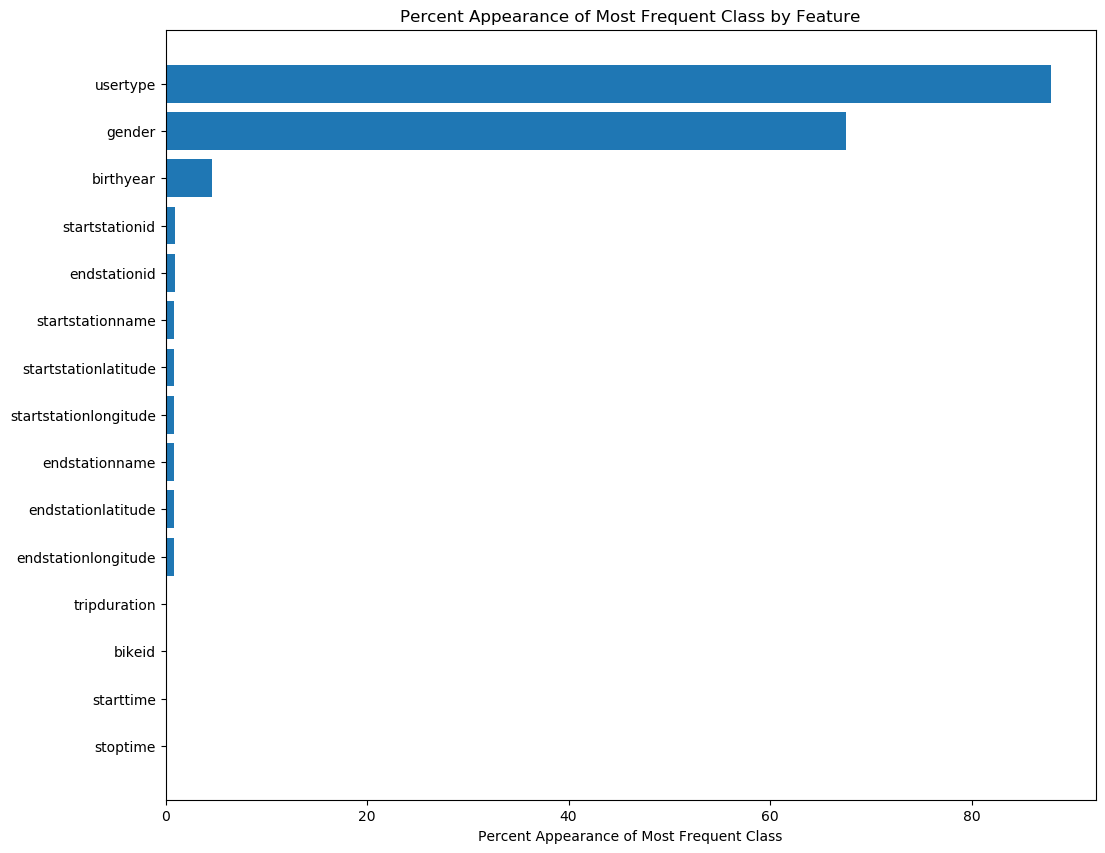

In [90]:
percent_class = pd.DataFrame()
percent_class['Percent_of_Class'] = l_init
percent_class['Feature_Name'] = fin_dat.columns
percent_class.sort_values(by='Percent_of_Class', ascending=False)['Percent_of_Class'][:50]

percent_class.sort_values(by='Percent_of_Class', ascending=False)
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(12,10))

ft = percent_class.sort_values(by='Percent_of_Class', ascending=False)['Feature_Name'][:50]
per = percent_class.sort_values(by='Percent_of_Class', ascending=False)['Percent_of_Class'][:50]
y_pos = np.arange(15)
ax.barh(y_pos, per, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ft)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Percent Appearance of Most Frequent Class')
ax.set_title('Percent Appearance of Most Frequent Class by Feature')